In [1]:
## Import necessary imports for data analysis and ML algorithm training.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [106]:
citrus_df = pd.read_csv("citrus.csv")
citrus_df

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9
...,...,...,...,...,...,...
9995,grapefruit,15.35,253.89,149,77,20
9996,grapefruit,15.41,254.67,148,68,7
9997,grapefruit,15.59,256.50,168,82,20
9998,grapefruit,15.92,260.14,142,72,11


# Proposed Business Problem:

WhatPlayNext inc. is a (fictional) North American IT consulting firm that specializes in offering video game publishers advice on what kind of games to work on next to maximize revenue. Historically, WhatPlayNext has derived its recommendations from research conducted by large teams of industry experts who would manually study sources including, but not limited to, video game sales data, social media trends, and the sum of their own personal experiences. This approach has proven to be costly, however, and has been met with mixed success by clients. As a result, WhatPlayNext's client base has begun to shrink, due to declining client confidence in the company's advice.

# Proposed ML-Based Solution

As WhatPlayNext's recently hired ML engineer, I will devise a ML model capable of predicting the revenue generated by any proposed video game given the game's genre, platform, and publisher within 10% of the game's actual revenue 70% of the time.

## Step 1. Prep Data for ML Training

In [107]:
# Check for any missing values....
citrus_data.isna().sum()

name        0
diameter    0
weight      0
red         0
green       0
blue        0
dtype: int64

In [108]:
citrus_data.head()

,name,diameter,weight,red,green,blue
0,orange,2.96,86.76,172,85,2
1,orange,3.91,88.05,166,78,3
2,orange,4.42,95.17,156,81,2
3,orange,4.47,95.60,163,81,4
4,orange,4.48,95.76,161,72,9


In [110]:
from sklearn.model_selection import train_test_split

X = citrus_data.drop("name", axis=1)
y = citrus_data["name"]

# Need to split the data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Split the training sets further into training and validation sets.
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)

In [132]:
# Now, to convert the the categorical data column to numeric data.
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_valid_encoded = encoder.transform(y_valid)
y_test_encoded = encoder.transform(y_test)

## Step 2: Choose ML estimator/algorithm

![Scikit Learn Choice Map](https://scikit-learn.org/stable/_static/ml_map.png)

Using the above decision tree, our first attempt should be to use the Linear SVC model.

In [142]:
from sklearn.svm import LinearSVC

model = LinearSVC(max_iter=10000)
model.fit(X_train, y_train_encoded)

/Users/brandonchavez/documents/projects/wgu-capstone/env/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(max_iter=10000)

In [146]:
# The data might be taking too long to converge because the values for
# each column are on vastly different scales. Let's try scaling each feature
# to a value between 0 and 1.0 before trying again.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train, y_train_encoded)
X_valid_scaled = scaler.fit_transform(X_valid, y_valid_encoded)
X_test_scaled = scaler.fit_transform(X_test, y_test_encoded)

In [156]:
np.random.seed(17)

model = LinearSVC(max_iter=100000)
model.fit(X_train_scaled, y_train_encoded)
model.score(X_valid_scaled, y_valid_encoded)

0.953125

In [157]:
model.score(X_train_scaled, y_train_encoded)

0.96046875

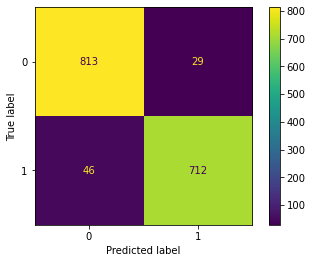

In [166]:
# The model appears to have done well on the validation dataset, but we
# should take further metrics to assess the model's predictive performance.
# Let's start by making a Confusion Matrix.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(estimator=model, X=X_valid_scaled, y=y_valid_encoded)

In [173]:
# A classfication report couldn't hurt either.
from sklearn.metrics import classification_report
y_preds = model.predict(X_valid_scaled)

print(classification_report(y_valid_encoded, y_preds))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       842
           1       0.94      0.94      0.94       758

    accuracy                           0.94      1600
   macro avg       0.94      0.94      0.94      1600
weighted avg       0.95      0.94      0.95      1600



In [175]:
# Looking pretty great! Let's move on to the test sets and see if 
# the model's performance holds up and seems reasonable.
model.score(X_test_scaled, y_test_encoded)

0.9535

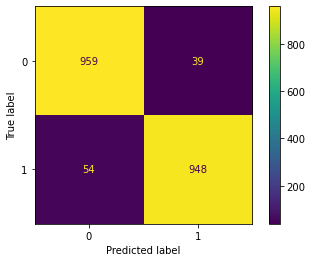

In [178]:
# Run the same performance metrics as was done for validation data.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(estimator=model, X=X_test_scaled, y=y_test_encoded)

In [179]:
from sklearn.metrics import classification_report
y_predictions = model.predict(X_test_scaled)

print(classification_report(y_test_encoded, y_predictions))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       998
           1       0.96      0.95      0.95      1002

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



In [180]:
# Looks like we have a working model!!